In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 32 virtual cores)
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [2]:
import Pkg; Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [3]:
import Pkg; Pkg.add("RCall")
import Pkg; Pkg.add("BenchmarkTools")
import Pkg; Pkg.add("PyCall")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [4]:
using RCall

# show R information
R"""
sessionInfo()
"""

RObject{VecSxp}
R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
[1] compiler_4.3.2


# 3  Gibbs sampler example by Doug Bates

* Doug Bates (member of R-Core, author of popular R packages Matrix, lme4, RcppEigen, etc)

    As some of you may know, I have had a (rather late) mid-life crisis and run off with another language called Julia.

        -- Doug Bates (on the `knitr` Google Group)

* An example from Dr. Doug Bates's slides Julia for R Programmers.
* The task is to create a Gibbs sampler for the density

$$ f(x,y) = kx^2exp(−xy^2−y^2+2y−4x),x>0 $$ 

* using the conditional distributions

$$X|Y ∼ \Gamma(3, \frac{1}{y^2+4})$$

$$Y|X ∼ N(\frac{1}{1+x}, \frac{1}{2(1+x)})$$

* R solution. The ```RCall.jl``` package allows us to execute R code without leaving the Julia environment. We first define an R function ```Rgibbs()```.


In [5]:
# define a function for Gibbs sampling

R"""
library(Matrix)

Rgibbs <- function(N, thin) {
  mat <- matrix(0, nrow=N, ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    for (j in 1:thin) {
      x <- rgamma(1, 3, y * y + 4) # 3rd arg is rate
      y <- rnorm(1, 1 / (x + 1), 1 / sqrt(2 * (x + 1)))
    }
    mat[i,] <- c(x, y)
  }
  mat
}
"""


RObject{ClosSxp}
function (N, thin) 
{
    mat <- matrix(0, nrow = N, ncol = 2)
    x <- y <- 0
    for (i in 1:N) {
        for (j in 1:thin) {
            x <- rgamma(1, 3, y * y + 4)
            y <- rnorm(1, 1/(x + 1), 1/sqrt(2 * (x + 1)))
        }
        mat[i, ] <- c(x, y)
    }
    mat
}


In [6]:
R"""
system.time(Rgibbs(10000, 500))
"""

RObject{RealSxp}
   user  system elapsed 
 31.839   0.142  32.010 


In [7]:
using Distributions

function jgibbs(N, thin)
    mat = zeros(N, 2)
    x = y = 0.0
    for i in 1:N
        for j in 1:thin
            x = rand(Gamma(3, 1 / (y * y + 4)))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2(x + 1))))
        end
        mat[i, 1] = x
        mat[i, 2] = y
    end
    mat
end

jgibbs (generic function with 1 method)

In [8]:
@time jgibbs(10, 5); # warm-up

  0.000010 seconds (1 allocation: 224 bytes)


In [11]:
@time ran_mat = jgibbs(10_000, 500)

  0.227208 seconds (2 allocations: 156.297 KiB)


10000×2 Matrix{Float64}:
 0.409338   0.43239
 1.10499   -0.235915
 0.892735   0.462302
 0.483392  -0.751131
 0.468735   1.1381
 0.506343   1.12186
 0.471303   1.75773
 1.08645    0.733124
 0.069997   1.29347
 0.177287   0.739147
 0.587546   0.217894
 0.119789   0.913161
 0.581595   1.14316
 ⋮         
 0.519539   0.686711
 1.02378    0.760795
 0.7764     0.599369
 0.670426   0.613017
 1.33836    0.289747
 1.03184   -0.04275
 0.733757   0.949267
 0.687235   0.937464
 0.593229   1.38069
 0.796098  -0.0184853
 0.823077   1.38802
 0.648063   0.179427

In [10]:
@time jgibbs(10000, 500)

  0.224623 seconds (2 allocations: 156.297 KiB)


10000×2 Matrix{Float64}:
 0.612259   1.17567
 1.23809    1.48454
 0.072775   0.807805
 0.156261   2.05845
 0.497491   0.548759
 0.393325   0.870751
 0.354889   1.13887
 0.151448   0.760766
 0.692153   1.70277
 0.601569   0.100824
 1.15805    0.21858
 0.499441  -0.288511
 0.244028   0.996618
 ⋮         
 0.746624   1.06146
 0.505984   0.641275
 0.391536   0.0809999
 1.30896    0.693325
 0.18596    1.13613
 0.184699   0.592469
 0.423879   0.96205
 0.503209   0.529788
 0.718789   1.58601
 0.94641    0.497592
 0.674772   1.38077
 0.158291  -0.197268

We see 40-80 fold speed up of Julia over R on this example, *with similar coding effort!*


# 4  Comparing C, R, Python, and Julia

To better understand how these languages work, we consider a simple task: summing a vector.

Let's first generate data: 1 million double precision numbers from uniform [0, 1].

In [14]:
using Random # standard library
Random.seed!(123) # seed
x = rand(1_000_000) # 1 million random numbers in [0, 1)
sum(x)

500220.6882968192

In [15]:
typeof(x)

Vector{Float64} (alias for Array{Float64, 1})

In [16]:
using BenchmarkTools

## 4.1  C

We would use the low-level C code as the baseline for copmarison. In Julia, we can easily run compiled C code using the ccall function.

### 4.1.1 vanilla C

In [17]:
using Libdl

C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -O3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [87]:
println(Clib)
println(Libdl.dlext)

/tmp/jl_I1K1lj
so


In [84]:
# make sure it gives same answer
@elapsed c_sum(x)

0.019864603

In [85]:
bm = @benchmark c_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     968.983 μs (0.00% GC)
  median time:      969.026 μs (0.00% GC)
  mean time:        994.527 μs (0.00% GC)
  maximum time:     4.872 ms (0.00% GC)
  --------------
  samples:          5024
  evals/sample:     1

$\mu s$ is microsecond, $10^{-6}$ of a second.

In [51]:
println(typeof(bm.times))
println(size(bm.times))
println(sizeof(bm.times))


Array{Float64,1}
(5121,)
40968


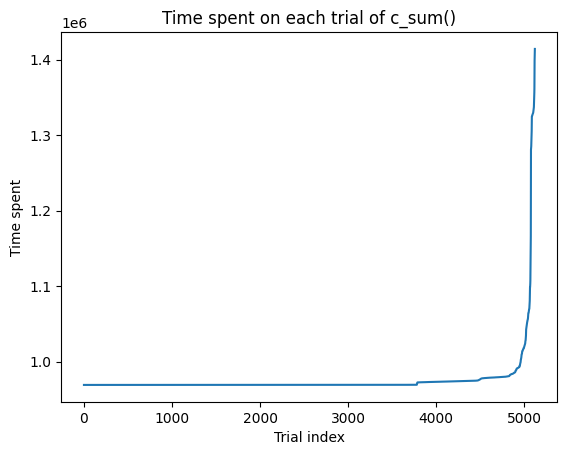

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec61d9c160>

In [58]:
using PyPlot # load the functionality into Julia
PyPlot.title("Time spent on each trial of c_sum()")
PyPlot.xlabel("Trial index")
PyPlot.ylabel("Time spent")
plot(bm.times)

In [55]:


using Gadfly # load the functionality into Julia
Gadfly.plot(y=bm.times, Geom.point, Geom.line, 
    Guide.xlabel("Index"), Guide.ylabel("Time"),
    Guide.title("Time spent on each trial of c_sum()"))

In [18]:
using Statistics # standard library
benchmark_result = Dict() # a dictionary to store median runtime (in milliseconds)

# store median runtime (in milliseconds)
benchmark_result["C"] = median(bm.times) / 1e6

0.969006

###  4.1.2 Try C pointer iteration

In [63]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double * X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += *(X++);
    }
    return s;
}
"""

const Clib3 = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -O3 -msse3 -xc -shared -o $(Clib3 * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_iter_sum(X::Array{Float64}) = ccall(("c_sum", Clib3), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_iter_sum (generic function with 1 method)

In [64]:
println(c_iter_sum(x))
bm = @benchmark c_iter_sum($x)

500060.340723512


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     968.984 μs (0.00% GC)
  median time:      969.040 μs (0.00% GC)
  mean time:        976.916 μs (0.00% GC)
  maximum time:     5.243 ms (0.00% GC)
  --------------
  samples:          5115
  evals/sample:     1

In [65]:
benchmark_result["C_iter"] = median(bm.times) / 1e6

0.96904

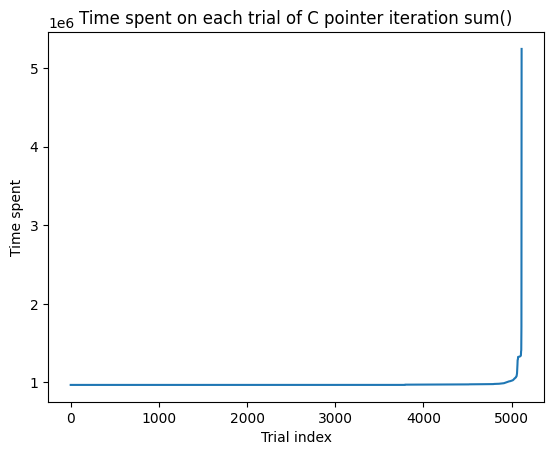

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec61c41160>

In [67]:
using PyPlot # load the functionality into Julia
PyPlot.title("Time spent on each trial of C pointer iteration sum()")
PyPlot.xlabel("Trial index")
PyPlot.ylabel("Time spent")
plot(bm.times)

### 4.1.3 Try C SIMD from OpenMP

https://www.openmp.org/spec-html/5.0/openmpsu42.html

Summary: The simd construct can be applied to a loop to indicate that the loop can be transformed into a SIMD loop (that is, multiple iterations of the loop can be executed concurrently using SIMD instructions). 

In [68]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double * X) {
    double s = 0.0;
    #pragma omp simd reduction(+: s)
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib4 = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -fopenmp -O3 -msse3 -xc -shared -o $(Clib4 * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_simd_sum(X::Array{Float64}) = ccall(("c_sum", Clib4), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_simd_sum (generic function with 1 method)

In [69]:
println(c_simd_sum(x))
bm = @benchmark c_simd_sum($x)

500060.3407235143


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     484.606 μs (0.00% GC)
  median time:      484.634 μs (0.00% GC)
  mean time:        489.061 μs (0.00% GC)
  maximum time:     5.134 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [70]:
benchmark_result["C_simd"] = median(bm.times) / 1e6

0.484634

### 4.1.4 Try C SIMD with native machine architecture compilation

Using -march=native enables all instruction subsets supported by the local machine (hence the result might not run on different machines).

In [71]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double * X) {
    double s = 0.0;
    #pragma omp simd reduction(+: s)
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib5 = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -march=native -fopenmp -O3 -msse3 -xc -shared -o $(Clib5 * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_simd_native_sum(X::Array{Float64}) = ccall(("c_sum", Clib5), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_simd_native_sum (generic function with 1 method)

In [72]:
println(c_simd_native_sum(x))
bm = @benchmark c_simd_native_sum($x)

500060.3407235272


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     270.801 μs (0.00% GC)
  median time:      272.125 μs (0.00% GC)
  mean time:        283.471 μs (0.00% GC)
  maximum time:     4.126 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [73]:
benchmark_result["C_simd_native"] = median(bm.times) / 1e6

0.272125

### 4.1.5 Try C native machine architecture compilation

In [81]:
C_code = """
#include <stddef.h>
double c_native_sum(size_t n, double * X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib6 = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -march=native -O3 -ftree-vectorize -msse3 -xc -shared -o $(Clib6 * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_native_sum(X::Array{Float64}) = ccall(("c_native_sum", Clib6), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_native_sum (generic function with 1 method)

In [82]:
println(c_native_sum(x))
bm = @benchmark c_native_sum($x)

500060.340723512


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     968.986 μs (0.00% GC)
  median time:      969.041 μs (0.00% GC)
  mean time:        977.671 μs (0.00% GC)
  maximum time:     3.778 ms (0.00% GC)
  --------------
  samples:          5111
  evals/sample:     1

In [80]:
benchmark_result["C_native"] = median(bm.times) / 1e6

0.969014

## 4.2  R, buildin sum

Next we compare to the build in sum function in R, which is implemented using C.

In [19]:
using RCall

R"""
library(bench)
y <- $x
rbm_builtin <- bench::mark(sum(y))
"""

RObject{VecSxp}
# A tibble: 1 x 13
  expression   min median `itr/sec` mem_alloc `gc/sec` n_itr  n_gc total_time
  <bch:expr> <bch> <bch:>     <dbl> <bch:byt>    <dbl> <int> <dbl>   <bch:tm>
1 sum(y)     975µs  978µs      958.        0B        0   479     0      500ms
# … with 4 more variables: result <list>, memory <list>, time <list>, gc <list>


In [20]:
# store median runtime (in milliseconds)
@rget rbm_builtin # dataframe
benchmark_result["R builtin"] = median(rbm_builtin[!, :median]) * 1000

0.9775850921869278

## 4.3  R, handwritten loop

Handwritten loop in R is much slower.

In [21]:
using RCall

R"""
sum_r <- function(x) {
  s <- 0
  for (xi in x) {
    s <- s + xi
  }
  s
}
library(bench)
y <- $x
rbm_loop <- bench::mark(sum_r(y))
"""

RObject{VecSxp}
# A tibble: 1 x 13
  expression    min median `itr/sec` mem_alloc `gc/sec` n_itr  n_gc total_time
  <bch:expr> <bch:> <bch:>     <dbl> <bch:byt>    <dbl> <int> <dbl>   <bch:tm>
1 sum_r(y)   28.9ms 29.1ms      34.2    12.7KB        0    18     0      526ms
# … with 4 more variables: result <list>, memory <list>, time <list>, gc <list>


In [22]:
# store median runtime (in milliseconds)
@rget rbm_loop # dataframe
benchmark_result["R loop"] = median(rbm_loop[!, :median]) * 1000

29.06378946499899

## 4.4  R, Rcpp

Rcpp package is the easiest way to incorporate C++ code in R.

In [23]:
R"""
library(Rcpp)

cppFunction('double rcpp_sum(NumericVector x) {
  int n = x.size();
  double total = 0;
  for(int i = 0; i < n; ++i) {
    total += x[i];
  }
  return total;
}')
rcpp_sum
"""

RObject{ClosSxp}
function (x) 
.Call(<pointer: 0x7fec62fd9260>, x)


In [24]:
R"""
rbm_rcpp <- bench::mark(rcpp_sum(y))
"""

RObject{VecSxp}
# A tibble: 1 x 13
  expression     min median `itr/sec` mem_alloc `gc/sec` n_itr  n_gc total_time
  <bch:expr>  <bch:> <bch:>     <dbl> <bch:byt>    <dbl> <int> <dbl>   <bch:tm>
1 rcpp_sum(y) 1.31ms 1.32ms      707.    2.49KB        0   354     0      501ms
# … with 4 more variables: result <list>, memory <list>, time <list>, gc <list>


In [25]:
# store median runtime (in milliseconds)
@rget rbm_rcpp # dataframe
benchmark_result["R Rcpp"] = median(rbm_rcpp[!, :median]) * 1000

1.3218115782365203

## 4.5  Python, builtin sum

Built in function sum in Python.

In [59]:
using PyCall
PyCall.pyversion

v"3.6.5"

In [60]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")
bm = @benchmark $pysum($x)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     172.699 ms (0.00% GC)
  median time:      175.643 ms (0.00% GC)
  mean time:        176.639 ms (0.00% GC)
  maximum time:     186.373 ms (0.00% GC)
  --------------
  samples:          29
  evals/sample:     1

In [61]:
# store median runtime (in miliseconds)
benchmark_result["Python builtin"] = median(bm.times) / 1e6

175.642819

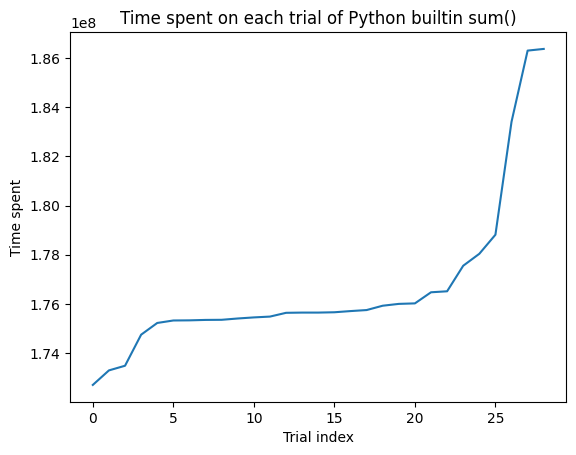

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec61cf7748>

In [62]:
using PyPlot # load the functionality into Julia
PyPlot.title("Time spent on each trial of Python builtin sum()")
PyPlot.xlabel("Trial index")
PyPlot.ylabel("Time spent")
plot(bm.times)

## 4.6  Python, handwritten loop

In [29]:
using PyCall

py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

bm = @benchmark $sum_py($x)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     207.382 ms (0.00% GC)
  median time:      208.094 ms (0.00% GC)
  mean time:        214.778 ms (0.00% GC)
  maximum time:     279.540 ms (0.00% GC)
  --------------
  samples:          24
  evals/sample:     1

In [30]:
# store median runtime (in miliseconds)
benchmark_result["Python loop"] = median(bm.times) / 1e6

208.094181

## 4.7  Python, numpy

Numpy is the high-performance scientific computing library for Python.

In [31]:
# bring in sum function from Numpy 
numpy_sum = pyimport("numpy")."sum"


PyObject <function sum at 0x7fec74b8e268>

In [32]:
bm = @benchmark $numpy_sum($x)


BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     389.146 μs (0.00% GC)
  median time:      390.151 μs (0.00% GC)
  mean time:        393.994 μs (0.00% GC)
  maximum time:     3.824 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [33]:
# store median runtime (in miliseconds)
benchmark_result["Python numpy"] = median(bm.times) / 1e6

0.390151

Numpy performance is on a par with Julia build-in sum function. Both are about 3 times faster than C, possibly because of usage of SIMD.

https://en.wikipedia.org/wiki/SIMD

## 4.8  Julia, builtin sum

@time, @elapsed, @allocated macros in Julia report run times and memory allocation

In [34]:
@time sum(x) # no compilation time after first run

  0.000724 seconds (1 allocation: 16 bytes)


500060.34072352527

For more robust benchmarking, we use BenchmarkTools.jl package.

In [35]:
bm = @benchmark sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     251.130 μs (0.00% GC)
  median time:      252.262 μs (0.00% GC)
  mean time:        253.589 μs (0.00% GC)
  maximum time:     836.530 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [36]:
benchmark_result["Julia builtin"] = median(bm.times) / 1e6

0.252262

## 4.9  Julia, handwritten loop

Let's also write a loop and benchmark.

In [88]:
function jl_sum(A)
    s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

bm = @benchmark jl_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     969.007 μs (0.00% GC)
  median time:      969.040 μs (0.00% GC)
  mean time:        977.383 μs (0.00% GC)
  maximum time:     5.707 ms (0.00% GC)
  --------------
  samples:          5112
  evals/sample:     1

In [38]:
benchmark_result["Julia loop"] = median(bm.times) / 1e6

0.969037

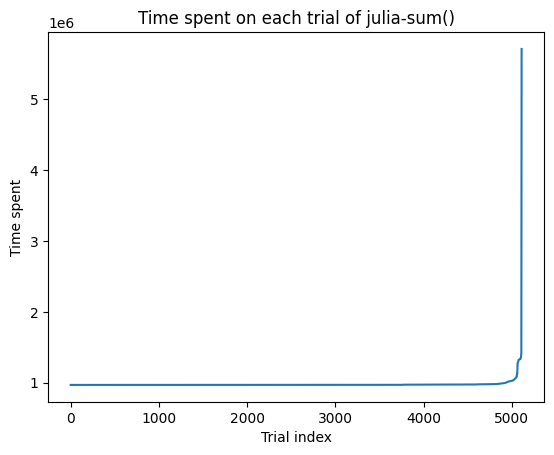

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec61c1d5c0>

In [89]:
using PyPlot # load the functionality into Julia
PyPlot.title("Time spent on each trial of julia-sum()")
PyPlot.xlabel("Trial index")
PyPlot.ylabel("Time spent")
plot(bm.times)

In [106]:
@code_llvm jl_sum(x)


;  @ In[88]:1 within `jl_sum'
define double @julia_jl_sum_10008(%jl_value_t* nonnull align 16 dereferenceable(40)) {
top:
;  @ In[88]:3 within `jl_sum'
; ┌ @ array.jl:785 within `iterate' @ array.jl:785
; │┌ @ array.jl:219 within `length'
    %1 = bitcast %jl_value_t* %0 to %jl_array_t*
    %2 = getelementptr inbounds %jl_array_t, %jl_array_t* %1, i64 0, i32 1
    %3 = load i64, i64* %2, align 8
; │└
   %4 = icmp slt i64 %3, 1
   br i1 %4, label %L43, label %L18

L18:                                              ; preds = %top
; │┌ @ array.jl:809 within `getindex'
    %5 = bitcast %jl_value_t* %0 to double**
    %6 = load double*, double** %5, align 8
    %7 = load double, double* %6, align 8
; └└
;  @ In[88]:4 within `jl_sum'
; ┌ @ float.jl:401 within `+'
   %8 = fadd double %7, 0.000000e+00
; └
; ┌ @ array.jl:785 within `iterate'
; │┌ @ int.jl:447 within `<' @ int.jl:440
    %9 = icmp eq i64 %3, 1
; │└
   br i1 %9, label %L43, label %L37

L37:                                        

In [98]:
@code_native jl_sum(x)

	.text
; ┌ @ In[88]:3 within `jl_sum'
; │┌ @ array.jl:785 within `iterate' @ array.jl:785
; ││┌ @ array.jl:219 within `length'
	movq	8(%rdi), %rax
; ││└
	testq	%rax, %rax
	jle	L46
; ││┌ @ array.jl:809 within `getindex'
	movq	(%rdi), %rcx
	vxorpd	%xmm0, %xmm0, %xmm0
; │└└
; │ @ In[88]:4 within `jl_sum'
; │┌ @ float.jl:401 within `+'
	vaddsd	(%rcx), %xmm0, %xmm0
; │└
; │┌ @ array.jl:785 within `iterate'
; ││┌ @ int.jl:447 within `<' @ int.jl:440
	cmpq	$1, %rax
; ││└
	je	L45
; └└
; ┌ @ array.jl within `jl_sum'
	movl	$1, %edx
	nop
; └
; ┌ @ In[88]:4 within `jl_sum'
; │┌ @ float.jl:401 within `+'
L32:
	vaddsd	(%rcx,%rdx,8), %xmm0, %xmm0
; │└
; │┌ @ array.jl:785 within `iterate'
; ││┌ @ int.jl:447 within `<' @ int.jl:440
	incq	%rdx
	cmpq	%rax, %rdx
; ││└
	jb	L32
; │└
; │ @ In[88]:6 within `jl_sum'
L45:
	retq
L46:
	vxorps	%xmm0, %xmm0, %xmm0
; │ @ In[88]:6 within `jl_sum'
	retq
	nopw	%cs:(%rax,%rax)
	nopl	(%rax)
; └


### 4.9.1 Exercise: annotate the loop by @simd and benchmark again.

https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-annotations-1

In [90]:
function jl_simd_sum(A)
    s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

bm_simd = @benchmark jl_simd_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     241.486 μs (0.00% GC)
  median time:      242.434 μs (0.00% GC)
  mean time:        244.542 μs (0.00% GC)
  maximum time:     3.114 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [92]:
benchmark_result["Julia SIMD loop"] = median(bm_simd.times) / 1e6

0.242434

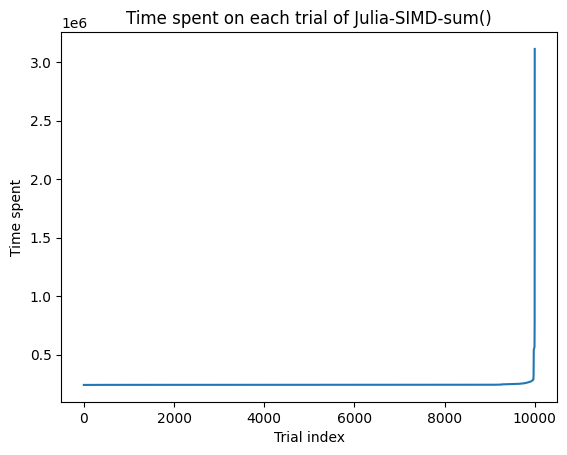

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec61b62358>

In [95]:
using PyPlot # load the functionality into Julia
PyPlot.title("Time spent on each trial of Julia-SIMD-sum()")
PyPlot.xlabel("Trial index")
PyPlot.ylabel("Time spent")
plot(bm_simd.times)

In [105]:
@code_llvm jl_simd_sum(x)


;  @ In[90]:1 within `jl_simd_sum'
define double @julia_jl_simd_sum_10007(%jl_value_t* nonnull align 16 dereferenceable(40)) {
top:
;  @ In[90]:3 within `jl_simd_sum'
; ┌ @ simdloop.jl:71 within `macro expansion'
; │┌ @ simdloop.jl:51 within `simd_inner_length'
; ││┌ @ array.jl:219 within `length'
     %1 = bitcast %jl_value_t* %0 to %jl_array_t*
     %2 = getelementptr inbounds %jl_array_t, %jl_array_t* %1, i64 0, i32 1
     %3 = load i64, i64* %2, align 8
; │└└
; │ @ simdloop.jl:72 within `macro expansion'
; │┌ @ int.jl:82 within `<'
    %4 = icmp slt i64 %3, 1
; │└
   br i1 %4, label %L18, label %L10.lr.ph

L10.lr.ph:                                        ; preds = %top
; │ @ simdloop.jl:76 within `macro expansion'
; │┌ @ simdloop.jl:54 within `simd_index'
; ││┌ @ array.jl within `getindex'
     %5 = bitcast %jl_value_t* %0 to double**
     %6 = load double*, double** %5, align 8
; │└└
; │ @ simdloop.jl:75 within `macro expansion'
   %min.iters.check = icmp ult i64 %3, 16
   br i1

In [97]:
@code_native jl_simd_sum(x)

	.text
; ┌ @ In[90]:3 within `jl_simd_sum'
; │┌ @ simdloop.jl:71 within `macro expansion'
; ││┌ @ simdloop.jl:51 within `simd_inner_length'
; │││┌ @ array.jl:219 within `length'
	movq	8(%rdi), %rax
; ││└└
; ││ @ simdloop.jl:72 within `macro expansion'
; ││┌ @ int.jl:82 within `<'
	testq	%rax, %rax
; ││└
	jle	L26
; ││ @ simdloop.jl:76 within `macro expansion'
; ││┌ @ simdloop.jl:54 within `simd_index'
; │││┌ @ array.jl within `getindex'
	movq	(%rdi), %rcx
; ││└└
; ││ @ simdloop.jl:75 within `macro expansion'
	cmpq	$16, %rax
	jae	L31
; └└
; ┌ @ simdloop.jl within `jl_simd_sum'
	vxorpd	%xmm0, %xmm0, %xmm0
	xorl	%edx, %edx
	jmp	L144
L26:
	vxorps	%xmm0, %xmm0, %xmm0
; └
; ┌ @ In[90]:6 within `jl_simd_sum'
	retq
; │ @ In[90]:3 within `jl_simd_sum'
; │┌ @ simdloop.jl:75 within `macro expansion'
L31:
	movl	%eax, %esi
	andl	$15, %esi
	movq	%rax, %rdx
	subq	%rsi, %rdx
	vxorpd	%xmm0, %xmm0, %xmm0
	xorl	%esi, %esi
	vxorpd	%xmm1, %xmm1, %xmm1
	vxorpd	%xmm2, %xmm2, %xmm2
	vxorpd	%xmm3, %xmm3, %xmm3


* Four registers (xmm0-3, ymm0-3) are used instead of one register (xmm0) in the SIMD Julia loop.

## 4.10  Summary

In [93]:
sort(collect(benchmark_result), by = x -> x[2])

14-element Array{Pair{Any,Any},1}:
 "Julia SIMD loop" => 0.242434
   "Julia builtin" => 0.252262
   "C_simd_native" => 0.272125
    "Python numpy" => 0.390151
          "C_simd" => 0.484634
               "C" => 0.969006
        "C_native" => 0.969014
      "Julia loop" => 0.969037
          "C_iter" => 0.96904
       "R builtin" => 0.9775850921869278
          "R Rcpp" => 1.3218115782365203
          "R loop" => 29.06378946499899
  "Python builtin" => 175.642819
     "Python loop" => 208.094181

* C, R builtin are the baseline C performance (gold standard).
* Python builtin and Python loop are 80-100 fold slower than C because the loop is interpreted.
* R loop is about 30 folder slower than C and indicates the performance of JIT bytecode generated by its compiler package (turned on by default since R v3.4.0 (Apr 2017)).
* Julia loop is close to C performance, because Julia code is JIT compiled.
* Julia builtin and Python numpy are 3-4 folder faster than C because of SIMD/AVX.



# 5  Take home message for computational scientists¶

* High-level language (R, Python, Matlab) programmers should be familiar with existing high-performance packages. Don't reinvent wheels.
  * R: RcppEigen, tidyverse, ...
  * Python: numpy, scipy, ...

* In most research projects, looping is unavoidable. Then we need to use a low-level language.
  * R: Rcpp, ...
  * Python: Cython, ...

* In this course, we use Julia, which seems to circumvent the two language problem. So we can spend more time on algorithms, not on juggling ≥2 languages.

In [3]:
exp(3)

20.085536923187668

In [4]:
isinf(3)

false

In [5]:
div(3,2)

1

In [6]:
fld(3,2)

1

In [7]:
cld(3,2)

2

In [8]:
rem(3,2)

1

In [9]:
mod(3,2)

1

In [10]:
mod1(3,2)

1

In [11]:
mod1(3,-2)

-1

In [13]:
mod2pi(30)

4.867258771281654

In [14]:
divrem(3,2)

(1, 1)

In [16]:
gcd(3,6,9)

3

In [17]:
lcm(3,6,9)

18

In [19]:
flipsign(3,-2)

-3

In [20]:
cbrt(3)

1.4422495703074083

In [21]:
sqrt(3)

1.7320508075688772

In [23]:
hypot(3,1)

3.1622776601683795

In [25]:
sqrt(10)

3.1622776601683795

In [26]:
hypot(3)

3.0

In [28]:
ldexp(3.0,2)

12.0

In [29]:
ldexp(3,2)

LoadError: MethodError: no method matching ldexp(::Int64, ::Int64)
Closest candidates are:
  ldexp(!Matched::BigFloat, ::Int64) at mpfr.jl:625
  ldexp(!Matched::Float16, ::Integer) at math.jl:775
  ldexp(!Matched::T, ::Integer) where T<:Union{Float16, Float32, Float64} at math.jl:733
  ...

In [31]:
exponent(1024.0)

10

In [32]:
significand(1024.0)

1.0

In [33]:
expm1(3)

19.085536923187668

In [35]:
sinpi(3)

0.0

In [36]:
cospi(3)

-1.0

In [37]:
sind(360)

0.0

# Test

In [7]:
qscore_cycle_37_tile_14 = [14, 37, 37, 37, 37, 14, 14, 37, 37, 32, 14, 14, 37, 37, 37, 14, 14, 37, 14, 37, 37, 37, 37, 37, 37, 37, 28, 37, 37, 37, 37, 37, 14, 37, 32, 14, 37, 37, 37, 14, 37, 14, 37, 37, 14, 14, 37, 37, 14, 37, 37, 14, 14, 14, 14, 14, 32, 14, 32, 14, 28, 32, 14, 14, 14, 14, 32, 14, 14, 14, 32, 14, 14, 28, 28, 14, 37, 14, 14, 14, 32, 14, 28, 14, 14, 32, 28, 14, 14, 28, 37, 37, 14, 14, 32, 32, 37, 28, 32, 14, 37, 14, 32, 14, 37, 32, 37, 32, 14, 32, 32, 37, 28, 14, 37, 37, 14, 32, 14, 14, 14, 14, 32, 14, 37, 14, 14, 37, 14, 28, 37, 14, 37, 14, 28, 14, 37, 37, 37, 37, 37, 32, 37, 14, 37, 37] 
display(length(qscore_cycle_37_tile_14))
typeof(qscore_cycle_37_tile_14)

146

Vector{Int64} (alias for Array{Int64, 1})

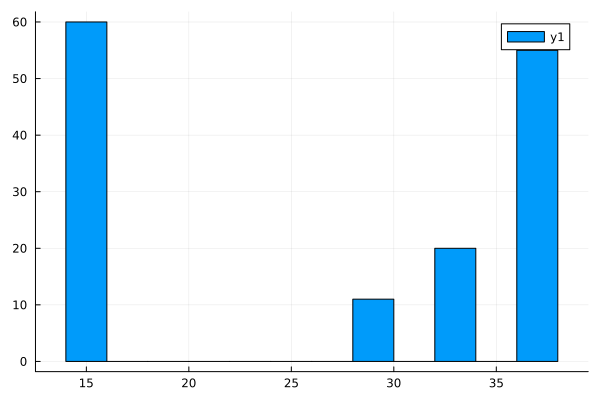

In [10]:
using Plots;
histogram(qscore_cycle_37_tile_14, bins=20)

In [8]:
60/146.

0.410958904109589

In [12]:
sum(qscore_cycle_37_tile_14)/length(qscore_cycle_37_tile_14)

26.184931506849313